In [1]:
from PIL import Image
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import vgg19
from torchvision.transforms import RandomCrop, ToTensor, Resize,Normalize, Compose
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from skimage.metrics import structural_similarity as ssim
from torchvision import transforms

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [3]:
class ImageDataset(Dataset):
    def __init__(self, hr_dir, crop_size=96, upscale_factor=4):
        self.hr_dir = hr_dir
        self.hr_files = os.listdir(hr_dir)
        self.hr_transform = RandomCrop(crop_size)
        self.upscale_factor = upscale_factor
        self.lr_size = crop_size // upscale_factor
        self.lr_transform = Resize((self.lr_size, self.lr_size), interpolation=Image.BICUBIC)
    
    def __len__(self):
        return len(self.hr_files)
    
    def __getitem__(self, idx):
        hr_name = os.path.join(self.hr_dir, self.hr_files[idx])
        # hr_img = Image.open(hr_name).convert('RGB')
        hr_img = Image.open(hr_name).convert('YCbCr')
        hr_y, cb, cr = hr_img.split()
        hr_y = self.hr_transform(hr_y)
        lr_y = self.lr_transform(hr_y)
        
        return {
            'hr_img': ToTensor()(hr_y),
            'lr_img': ToTensor()(lr_y)
        }

In [4]:
class ResidualDenseBlock(nn.Module):
    def __init__(self, in_channels, out_channels, beta=0.2):
        super(ResidualDenseBlock, self).__init__()
        self.beta = beta
        self.conv1 = nn.Conv2d(in_channels + out_channels * 0, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv2 = nn.Conv2d(in_channels + out_channels * 1, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv3 = nn.Conv2d(in_channels + out_channels * 2, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv4 = nn.Conv2d(in_channels + out_channels * 3, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv5 = nn.Conv2d(in_channels + out_channels * 4, in_channels, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.lRelu = nn.LeakyReLU(0.2, inplace=True)
        
    def forward(self, x):
        residual = x
        
        out1 = self.lRelu(self.conv1(x))
        out2 = self.lRelu(self.conv2(torch.cat([x, out1], 1)))
        out3 = self.lRelu(self.conv3(torch.cat([x, out1, out2], 1)))
        out4 = self.lRelu(self.conv4(torch.cat([x, out1, out2, out3], 1)))
        out5 = self.conv5(torch.cat([x, out1, out2, out3, out4], 1))
        
        out5 = torch.mul(out5, self.beta)
        return out5 + residual
        
class ResidualResidualDenseBlock(nn.Module):
    def __init__(self, in_channels, out_channels, beta = 0.2):
        super(ResidualResidualDenseBlock, self).__init__()
        self.beta = beta
        self.rdb1 = ResidualDenseBlock(in_channels, out_channels, beta)
        self.rdb2 = ResidualDenseBlock(in_channels, out_channels, beta)
        self.rdb3 = ResidualDenseBlock(in_channels, out_channels, beta)
    
    def forward(self, x):
        residual = x
        x = self.rdb1(x)
        x = self.rdb2(x)
        x = self.rdb3(x)
        x = torch.mul(x, self.beta)
        return x + residual
    
class UpSample(nn.Module):
    def __init__(self, in_channels, kernel_size=3, padding=1, stride=1, upScale_factor=2):
        super(UpSample, self).__init__()
        self.upsample = nn.Sequential(
            nn.Conv2d(in_channels, in_channels * (upScale_factor ** 2), kernel_size=kernel_size, stride=stride, padding=padding),
            nn.PixelShuffle(upScale_factor),
            nn.PReLU()
        )
    
    def forward(self, x):
        return self.upsample(x)
    
class Generator(nn.Module):
    def __init__(self, num_Res_blocks = 16, upScale_factor = 4, num_res_block_channels = 64):
        super(Generator, self).__init__()
        
        self.intial_block = nn.Sequential(
            nn.Conv2d(1, num_res_block_channels, kernel_size=9, stride=1, padding=4),
            nn.PReLU()
        )
        self.res_block = nn.Sequential(*[ResidualResidualDenseBlock(in_channels=num_res_block_channels, out_channels=32) for _ in range(num_Res_blocks)])
        self.post_res = nn.Conv2d(num_res_block_channels, num_res_block_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.upsample_block = nn.Sequential(*[UpSample(num_res_block_channels) for _ in range(upScale_factor // 2)])
        self.final = nn.Conv2d(num_res_block_channels, 1, kernel_size=9, stride=1, padding=4)
        
    def forward(self, x):
        initial = self.intial_block(x)
        res = self.res_block(initial)
        post_residual = self.post_res(res)
        x = initial + post_residual
        x = self.upsample_block(x)
        x = self.final(x)
        return torch.sigmoid(x)

In [5]:
class DiscriminatorBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, use_bn=True):
        super(DiscriminatorBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn = nn.BatchNorm2d(out_channels) if use_bn else None
        self.lrelu = nn.LeakyReLU(0.2, inplace=True)
        
    def forward(self, x):
        x = self.conv(x)
        if self.bn:
            x = self.bn(x)
        x = self.lrelu(x)
        return x

class Discriminator(nn.Module):
    def __init__(self, input_shape=(3,96,96)):
        super(Discriminator, self).__init__()
        self.features = nn.Sequential(
            DiscriminatorBlock(1, 64, use_bn=False),
            DiscriminatorBlock(64, 64, stride=2),
            DiscriminatorBlock(64, 128),
            DiscriminatorBlock(128, 128, stride=2),
            DiscriminatorBlock(128, 256),
            DiscriminatorBlock(256, 256, stride=2),
            DiscriminatorBlock(256, 512),
            DiscriminatorBlock(512, 512, stride=2),
        )
        
        self.output_shape = self.get_output_shape(input_shape)
        self.dense_block = nn.Sequential(
            nn.Linear(self.output_shape, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1)
        )
    
    def get_output_shape(self, input_shape):
        with torch.no_grad():
            dummy = torch.zeros(1, *input_shape)
            output = self.features(dummy)
            return int(torch.prod(torch.tensor(output.shape[1:])))
    
    def forward(self, x):
        features = self.features(x)
        flat = features.view(features.size(0), -1)
        return self.dense_block(flat)

In [6]:
def D_ra(real_logits, fake_logits):
    real_mean = torch.mean(fake_logits)
    fake_mean = torch.mean(real_logits)

    D_real = torch.sigmoid(real_logits - fake_mean)
    D_fake = torch.sigmoid(fake_logits - real_mean)

    return D_real, D_fake

def discriminator_loss(D, real_imgs, fake_imgs):
    real_logits = D(real_imgs)
    fake_logits = D(fake_imgs)
    
    D_real, D_fake = D_ra(real_logits, fake_logits)

    loss_real = torch.log(D_real + 1e-12).mean()
    loss_fake = torch.log(1 - D_fake + 1e-12).mean()
    return - (loss_real + loss_fake)

def generator_loss(D, real_imgs, fake_imgs):
    real_logits = D(real_imgs)
    fake_logits = D(fake_imgs)
    
    D_real, D_fake = D_ra(real_logits, fake_logits)

    loss_real = torch.log(1 - D_real + 1e-12).mean()
    loss_fake = torch.log(D_fake + 1e-12).mean()
    return - (loss_real + loss_fake)

class PercepLoss(nn.Module):
    def __init__(self):
        super(PercepLoss, self).__init__()
        vgg = vgg19(pretrained=True).features
        self.vgg_layers = nn.Sequential(*list(vgg)[:8]).eval()
        for param in self.vgg_layers.parameters():
            param.requires_grad = False
        
        self.register_buffer('mean', torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1))
        self.register_buffer('std', torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1))
    
    def forward(self, sr, hr):
        sr_norm = (sr - self.mean) / self.std
        hr_norm = (hr - self.mean) / self.std
        sr_vgg = self.vgg_layers(sr_norm)
        hr_vgg = self.vgg_layers(hr_norm)
        return F.mse_loss(sr_vgg, hr_vgg)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

dataset = ImageDataset(hr_dir="DIV2K_train_HR", crop_size=192)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)

generator = Generator().to(device)
discriminator = Discriminator(input_shape=(1,192,192)).to(device)

optimizer_G = optim.Adam(generator.parameters(), lr=2e-4,  betas=(0.9, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=2e-4,  betas=(0.9, 0.999))
scheduler_G = StepLR(optimizer_G, step_size=25, gamma=0.5)
scheduler_D = StepLR(optimizer_G, step_size=25, gamma=0.5)

criterion_percep_loss = PercepLoss().to(device)

bce_loss_G = nn.BCELoss()
bce_loss_D = nn.BCELoss()
pixel_loss = nn.L1Loss() 

weight_generator_loss = 5e-3
weight_l1_loss = 1e-2

num_epochs = 100

cuda


In [8]:
generator.to(device)
discriminator.to(device)

mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(device)
std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(device)

for epoch in range(100):  # Pre-train
    for i, batch in enumerate(dataloader):
        lr_imgs = batch['lr_img'].to(device)
        hr_imgs = batch['hr_img'].to(device)
        
        optimizer_G.zero_grad()
        sr_imgs = generator(lr_imgs)
        loss = pixel_loss(sr_imgs, hr_imgs)
        loss.backward()
        optimizer_G.step()
        
        if i % 10 == 0:
            print(f"Pre-train Epoch {epoch}, Batch {i}, Pixel Loss: {loss.item():.6f}")


for epoch in range(num_epochs):
    for i, imgs in enumerate(dataloader):
        
        lr_patch = imgs["lr_img"].to(device)
        hr_patch = imgs["hr_img"].to(device)
        
        # Train Discriminator
        optimizer_D.zero_grad()
        with torch.no_grad():
            sr_patch = generator(lr_patch.detach())
        d_loss = discriminator_loss(discriminator, hr_patch, sr_patch)
        d_loss.backward()
        optimizer_D.step()
        
        
        # Train Generator
        optimizer_G.zero_grad()
        
        sr_patch = generator(lr_patch)

        sr_norm = (sr_patch - mean) / std
        hr_norm = (hr_patch - mean) / std
        
        percep_loss = criterion_percep_loss(sr_patch, hr_patch)
        adverserial_loss = generator_loss(discriminator, hr_patch, sr_patch)
        l1_loss = pixel_loss(sr_patch, hr_patch)
        
        g_loss = percep_loss + (weight_generator_loss * adverserial_loss) + (weight_l1_loss * l1_loss)
        g_loss.backward()
        optimizer_G.step()

        if i % 10 == 0:
            print(f"Epoch {epoch}/{num_epochs}, Step {i}, G Loss: {g_loss.item()}, D Loss: {d_loss.item()}")
    
    scheduler_G.step()
    scheduler_D.step()

Pre-train Epoch 0, Batch 0, Pixel Loss: 0.272281
Pre-train Epoch 0, Batch 10, Pixel Loss: 0.122719
Pre-train Epoch 0, Batch 20, Pixel Loss: 0.098080
Pre-train Epoch 0, Batch 30, Pixel Loss: 0.099970
Pre-train Epoch 0, Batch 40, Pixel Loss: 0.071789
Pre-train Epoch 1, Batch 0, Pixel Loss: 0.071254
Pre-train Epoch 1, Batch 10, Pixel Loss: 0.056874
Pre-train Epoch 1, Batch 20, Pixel Loss: 0.040484
Pre-train Epoch 1, Batch 30, Pixel Loss: 0.052643
Pre-train Epoch 1, Batch 40, Pixel Loss: 0.062385
Pre-train Epoch 2, Batch 0, Pixel Loss: 0.049675
Pre-train Epoch 2, Batch 10, Pixel Loss: 0.084731
Pre-train Epoch 2, Batch 20, Pixel Loss: 0.056947
Pre-train Epoch 2, Batch 30, Pixel Loss: 0.053930
Pre-train Epoch 2, Batch 40, Pixel Loss: 0.050025
Pre-train Epoch 3, Batch 0, Pixel Loss: 0.033158
Pre-train Epoch 3, Batch 10, Pixel Loss: 0.039426
Pre-train Epoch 3, Batch 20, Pixel Loss: 0.047832
Pre-train Epoch 3, Batch 30, Pixel Loss: 0.048739
Pre-train Epoch 3, Batch 40, Pixel Loss: 0.053834
Pre-

In [ ]:
torch.save(generator.state_dict(), 'RRDB_ESRGAN.pth')

In [10]:
generator_PSNR = Generator().to(device)
optimizer_G_PSNR = optim.Adam(generator_PSNR.parameters(), lr=2e-4,  betas=(0.9, 0.999))
scheduler_G_PSNR = StepLR(optimizer_G_PSNR, step_size=25, gamma=0.5)

pixel_loss_PSNR = nn.L1Loss() 

num_epochs = 100

for epoch in range(100):  # Pre-train
    for i, batch in enumerate(dataloader):
        lr_imgs = batch['lr_img'].to(device)
        hr_imgs = batch['hr_img'].to(device)
        
        optimizer_G_PSNR.zero_grad()
        sr_imgs = generator_PSNR(lr_imgs)
        loss = pixel_loss_PSNR(sr_imgs, hr_imgs)
        loss.backward()
        optimizer_G_PSNR.step()
        
        if i % 10 == 0:
            print(f"Pre-train Epoch {epoch}, Batch {i}, Pixel Loss: {loss.item():.6f}")
    scheduler_G_PSNR.step()

Pre-train Epoch 0, Batch 0, Pixel Loss: 0.225250
Pre-train Epoch 0, Batch 10, Pixel Loss: 0.116799
Pre-train Epoch 0, Batch 20, Pixel Loss: 0.108455
Pre-train Epoch 0, Batch 30, Pixel Loss: 0.094184
Pre-train Epoch 0, Batch 40, Pixel Loss: 0.076129
Pre-train Epoch 1, Batch 0, Pixel Loss: 0.074104
Pre-train Epoch 1, Batch 10, Pixel Loss: 0.049542
Pre-train Epoch 1, Batch 20, Pixel Loss: 0.051428
Pre-train Epoch 1, Batch 30, Pixel Loss: 0.075294
Pre-train Epoch 1, Batch 40, Pixel Loss: 0.075154
Pre-train Epoch 2, Batch 0, Pixel Loss: 0.070549
Pre-train Epoch 2, Batch 10, Pixel Loss: 0.056631
Pre-train Epoch 2, Batch 20, Pixel Loss: 0.046902
Pre-train Epoch 2, Batch 30, Pixel Loss: 0.042657
Pre-train Epoch 2, Batch 40, Pixel Loss: 0.047039
Pre-train Epoch 3, Batch 0, Pixel Loss: 0.044965
Pre-train Epoch 3, Batch 10, Pixel Loss: 0.043280
Pre-train Epoch 3, Batch 20, Pixel Loss: 0.044730
Pre-train Epoch 3, Batch 30, Pixel Loss: 0.036254
Pre-train Epoch 3, Batch 40, Pixel Loss: 0.045731
Pre-

In [12]:
torch.save(generator_PSNR.state_dict(), 'RRDB_PSNR_x4.pth')

In [88]:
psnr_model_path = 'RRDB_PSNR_x4.pth'
gan_model_path = 'RRDB_ESRGAN.pth'
interpolated_model_path = 'RRDB_interp_x4.pth'

alpha = 0.0001

psnr_weights = torch.load(psnr_model_path)
gan_weights = torch.load(gan_model_path)

interpolated_weights = {}

for k in psnr_weights.keys():
    if k in gan_weights:
        interpolated_weights[k] = (1 - alpha) * psnr_weights[k] + alpha * gan_weights[k]
    else:
        print(f"Warning: key {k} not in GAN weights; using PSNR weight only.")
        interpolated_weights[k] = psnr_weights[k]

torch.save(interpolated_weights, interpolated_model_path)

/tmp/ipykernel_1318765/2699464540.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  psnr_weights = torch.load(psnr_model_path)
/tmp/ipykernel_1318765/2699464540.py:8: Futu

In [89]:
final_model = Generator().to(device)
interpolated_weights = torch.load('RRDB_interp_x4.pth')
final_model.load_state_dict(interpolated_weights)

final_model.eval()

/tmp/ipykernel_1318765/415843435.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  interpolated_weights = torch.load('RRDB_interp_x4.pth')


Generator(
  (intial_block): Sequential(
    (0): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): PReLU(num_parameters=1)
  )
  (res_block): Sequential(
    (0): ResidualResidualDenseBlock(
      (rdb1): ResidualDenseBlock(
        (conv1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (conv2): Conv2d(96, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (conv3): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (conv4): Conv2d(160, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (conv5): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (lRelu): LeakyReLU(negative_slope=0.2, inplace=True)
      )
      (rdb2): ResidualDenseBlock(
        (conv1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (conv2): Conv2d(96, 32, kernel_size=(3, 3), stride=(1, 1), padding

In [90]:
def inference(generator, hr_dir, lr_dir):
    val_files = os.listdir(hr_dir)

    hr_images = []
    hr_y_s = []
    sr_y_s = []
    cr_images = []
    cb_images = []
    generator.eval()
    with torch.no_grad():
        for file in val_files:
            hr_name = os.path.join(hr_dir, file)
            lr_name = os.path.join(lr_dir, file)
            hr_img = Image.open(hr_name).convert('YCbCr')
            hr_images.append(hr_img)
            hr_y,_,_ = hr_img.split()
            hr_y = ToTensor()(hr_y)
            hr_y_s.append(hr_y)
            lr_img = Image.open(lr_name).convert('YCbCr')
            lr_y,lr_cb,lr_cr = lr_img.split()
            lr_y = ToTensor()(lr_y).to(device)
            cr_images.append(lr_cr)
            cb_images.append(lr_cb)
            
            sr_y = generator(lr_y.unsqueeze(0))
            sr_y_s.append(sr_y.squeeze(0).cpu())
    return hr_images, hr_y_s, sr_y_s, cr_images, cb_images

def calculate_psnr(sr, hr):
    mse = F.mse_loss(sr, hr)
    return 10 * torch.log10(1.0 / mse)

def calculate_ssim(sr, hr):
    sr_np = sr.permute(1, 2, 0).numpy()
    hr_np = hr.permute(1, 2, 0).numpy()
    
    sr_np = np.clip(sr_np, 0, 1)
    hr_np = np.clip(hr_np, 0, 1)
    
    return ssim(sr_np, hr_np, data_range=1.0, channel_axis=2, multichannel=True)

def test(generator, hr_dir, lr_dir):
    hr_images, hr_y_s, sr_y_s, cr_images, cb_images = inference(generator, hr_dir, lr_dir)
    psnr_errors = []
    SSIM_errors = []
    for i in range(len(hr_y_s)):
        psnr_errors.append(calculate_psnr(sr_y_s[i], hr_y_s[i]).item())
        SSIM_errors.append(calculate_ssim(sr_y_s[i], hr_y_s[i]).item())
    
    return np.mean(psnr_errors), np.mean(SSIM_errors)

In [91]:
generator = Generator().to(device)
generator.load_state_dict(torch.load("RRDB_interp_x4.pth"))
generator.eval()

/tmp/ipykernel_1318765/2311589104.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load("RRDB_interp_x4.pth"))


Generator(
  (intial_block): Sequential(
    (0): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): PReLU(num_parameters=1)
  )
  (res_block): Sequential(
    (0): ResidualResidualDenseBlock(
      (rdb1): ResidualDenseBlock(
        (conv1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (conv2): Conv2d(96, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (conv3): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (conv4): Conv2d(160, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (conv5): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (lRelu): LeakyReLU(negative_slope=0.2, inplace=True)
      )
      (rdb2): ResidualDenseBlock(
        (conv1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (conv2): Conv2d(96, 32, kernel_size=(3, 3), stride=(1, 1), padding

In [92]:
hr_dir = "DIV2K_valid_HR"
lr_dir = "DIV2K_valid_LR_bicubic_X4"
psnr, SSIM = test(generator, hr_dir, lr_dir)
print(f'for the DIV2K validation set the PSNR is {psnr} and SSIM is {SSIM}')

for the DIV2K validation set the PSNR is 27.714592323303222 and SSIM is 0.7995191317796707


In [93]:
hr_dir = "Set5/HR"
lr_dir = "Set5/LR"
psnr, SSIM = test(generator, hr_dir, lr_dir)
print(f'for the Set5 dataset the PSNR is {psnr} and SSIM is {SSIM}')

for the Set5 dataset the PSNR is 28.51205062866211 and SSIM is 0.8416314721107483


In [94]:
hr_dir = "Set14/HR"
lr_dir = "Set14/LR"
psnr, SSIM = test(generator, hr_dir, lr_dir)
print(f'for the Set14 dataset the PSNR is {psnr} and SSIM is {SSIM}')

for the Set14 dataset the PSNR is 25.561971255711146 and SSIM is 0.7422554067202977


In [95]:

val_files = os.listdir("Set5/HR")

generator.eval()
with torch.no_grad():
        hr_name = os.path.join(hr_dir, val_files[2])
        lr_name = os.path.join(lr_dir, val_files[2])
        hr_img = Image.open(hr_name).convert('YCbCr')
        hr_y,_,_ = hr_img.split()
        lr_img = Image.open(lr_name).convert('YCbCr')
        lr_y,lr_cb,lr_cr = lr_img.split()
        lr_y = ToTensor()(lr_y).to(device)
        
        sr_y = generator(lr_y.unsqueeze(0))
        sr_y = sr_y.squeeze(0).cpu()

sr_y_np = sr_y.squeeze().cpu().clamp(0, 1).numpy() * 255.0
sr_y_np = sr_y_np.astype(np.uint8)
sr_y_img = Image.fromarray(sr_y_np, mode='L')

new_size = sr_y_img.size
cb_up = lr_cb.resize(new_size, Image.BICUBIC)
cr_up = lr_cr.resize(new_size, Image.BICUBIC)

img_ycbcr = Image.merge("YCbCr", [sr_y_img, cb_up, cr_up])
img_rgb = img_ycbcr.convert("RGB")
hr_img_rgb = hr_img.convert("RGB")

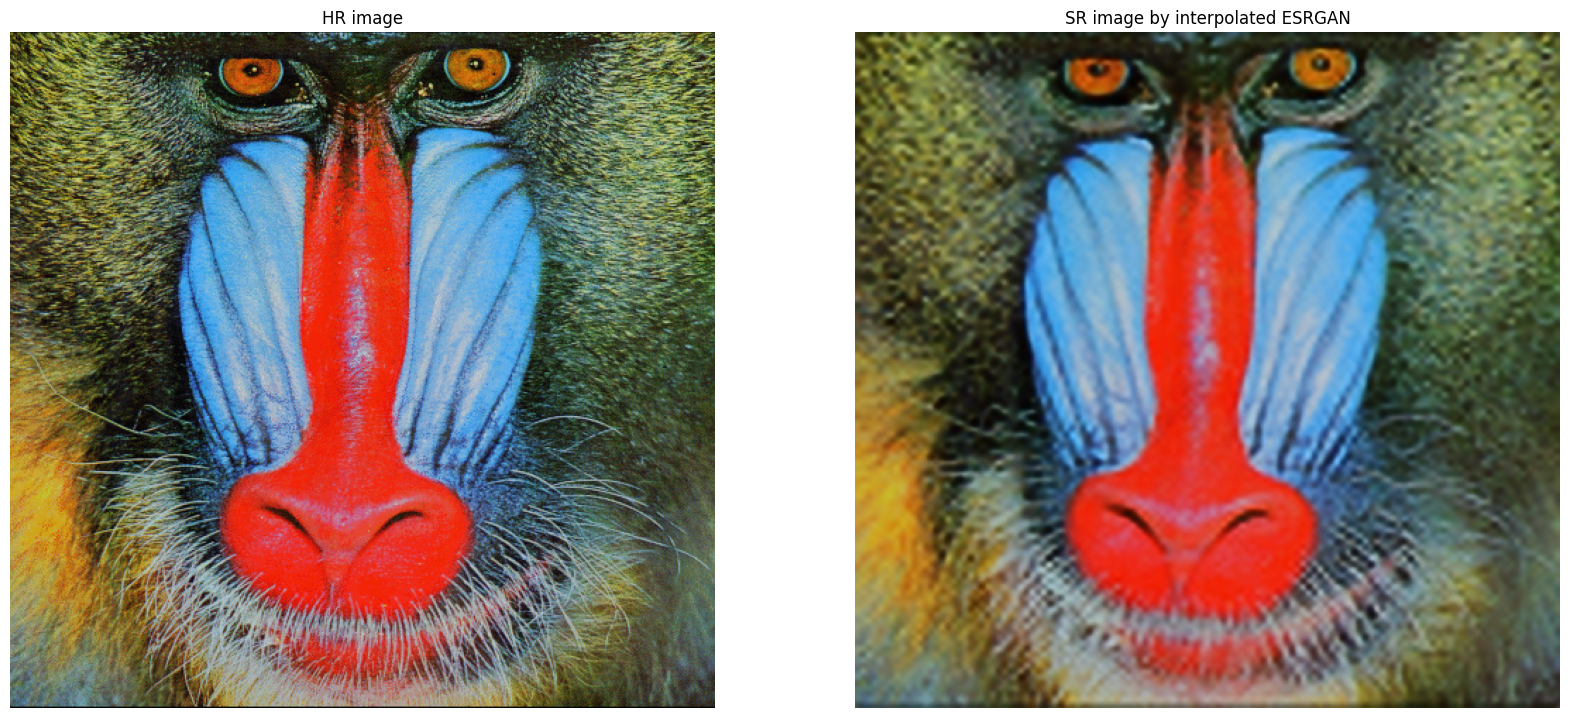

In [96]:
fig, ax = plt.subplots(1,2, figsize=(20, 10))

ax[0].imshow(hr_img_rgb)
ax[0].axis("off")
ax[0].set_title("HR image")

ax[1].imshow(img_rgb)
ax[1].axis("off")
ax[1].set_title("SR image by interpolated ESRGAN")

plt.show()
fig.savefig("compare_images_interp_ESRGAN.png")

In [97]:
img_rgb.save("SR_image_interp_ESRGAN.png")